<a class="anchor" id="Top"></a>
***
# **<font color='#4575b4'>Student Performance Analytics and Trend Analysis | March Madness Reading Challenge</font>**

## **S. Taylor**
***

## Project Introduction

The March Madness Student Reading Challenge is a school-wide initiative designed to encourage consistent reading habits among students from Kindergarten through 5th grade. Over a four-week period, students logged their reading minutes weekly, allowing teachers and administrators to monitor engagement, celebrate achievements, and identify areas where additional support may be needed.

This data-driven approach provides insights into individual and class-level reading performance, enabling targeted interventions, recognition of high achievers, and informed decisions to improve overall literacy engagement.

## Project Objective

The goal of this project is to provide actionable insights on student reading performance and engagement during the March Madness Reading Challenge:

1. [**Prepare Clean Data**](#sec_1)
    - Handle missing values.  
    - Remove duplicates.  
    - Standardize formats.  
    - Validate key metrics for reliability.
<br><br>
2. [**Recognize Top Performers**](#sec_2)
    - Identify high-achieving students, classes, and teachers.  
    - Celebrate success and establish performance benchmarks.
<br><br>
3. [**Highlight Students Needing Support**](#sec_3)
    - Detect students with zero or low reading points.  
    - Enable targeted interventions and support.
<br><br>
4. [**Track Reading Trends**](#sec_4)
    - Analyze week-to-week reading log progression.  
    - Monitor growth patterns and student engagement.
<br><br>
5. [**Examine Class Performance Distribution & Outliers**](#sec_5)
    - Explore performance distributions and identify outliers.  
    - Inform instructional strategies and resource allocation.

***
## Setup

**Data Source:**  
- CSV of student reading log points (`MM.csv`)  
- Columns: `Grade`, `Teacher`, `Student`, `RL1`, `RL2`, `RL3`, `RL4`, `TotalPoints`

**Tools & Libraries:**  
- Python: pandas, seaborn, matplotlib  
- SQL (SQLite) for aggregation  
- Jupyter Notebook for analysis and visualization

In [2]:
%%capture
# Install & import
!pip install pandas seaborn matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import sqlite3
#------------------------------
# Database connection
con = sqlite3.connect("MM.db")
cur = con.cursor()
#----------------------------------------------------------------
# SQL magic
%load_ext sql
%sql sqlite:///MM.db

***
## **<font color='#f46d43'>About Dataset</font>**

**Objective:** Provide a comprehensive view of student reading activity in the March Madness Reading Challenge, including weekly reading log minutes, total minutes, and class-level information.

**Key columns:**  
- `Grade` – Student grade (Kindergarten `K` through 5th grade)  
- `Teacher` – Homeroom teacher of the student  
- `Student` – Name of the student  
- `RL1` – Minutes read in Reading Log Week 1  
- `RL2` – Minutes read in Reading Log Week 2  
- `RL3` – Minutes read in Reading Log Week 3  
- `RL4` – Minutes read in Reading Log Week 4  
- `TotalPoints` – Sum of minutes read across all four weeks  

This dataset provides a detailed foundation for analyzing student performance, identifying trends, and comparing outcomes across grades and teachers.

In [3]:
%%capture
# Load CSV #
MMRC_df = pd.read_csv("MM.csv")

In [4]:
# View dataframe #
MMRC_df.sample(n=5)

,Grade,Teacher,Student,RL1,RL2,RL3,RL4,TotalPoints
364,5,Green,Anderson,NaN,NaN,NaN,NaN,0
315,4,Brown,Anafa,320.0,428.0,130.0,300.0,1178
8,K,Waldems,Eden,NaN,210.0,125.0,75.0,410
326,5,Wright,Aavyaan,1407.0,1371.0,670.0,1392.0,4840
148,2,McMahon,Daniel,145.0,NaN,NaN,130.0,275


<a class="anchor" id="sec_1"></a>
***
## **<font color='#f46d43'>Data Cleaning</font>**

**Objective:** Prepare the dataset for accurate and reliable analysis by handling missing data, removing duplicates, standardizing formats, and validating key metrics.

1. **Handling Missing Data**  
   - Student names are required; rows with missing `Student` values were removed.  
   - Missing weekly reading log values (`RL1`–`RL4`) were replaced with `0` to represent no recorded reading time.  
<br>
2. **Identifying and Removing Duplicates**  
   - Full-row duplicates were checked and none were found.  
   - Duplicate students within the same class (combination of `Student` and `Teacher`) were also checked.  
<br>
3. **Standardizing Formats**  
   - String columns (`Grade`, `Teacher`, `Student`) were checked for leading or trailing whitespace.  
   - No formatting issues were detected, ensuring uniformity across all records.  
<br>
4. **Setting Grade Hierarchy**  
   - `Grade` was converted to an ordered categorical variable from Kindergarten (`K`) through 5th grade to ensure proper sorting and aggregation.  
<br>
5. **Data Validation**  
   - Internal consistency was checked by comparing `TotalPoints` to the sum of weekly reading logs (`RL1`–`RL4`).  

After these steps, the dataset is clean, consistent, and ready for exploratory analysis, visualization, and deriving insights.

### Handle Missing Data

Missing data was addressed to ensure accuracy in downstream analysis. Student names were mandatory and any missing entries were dropped. Missing reading log values were replaced with zeros, reflecting students who did not record reading time for that week. This step ensures completeness and reliability of numerical analyses.

- Missing student names were dropped (4 rows), as student identification is mandatory for analysis.
- Missing weekly reading log values (`RL1`–`RL4`) were replaced with 0, representing students who did not log reading time for that week.

In [5]:
# Count of NaN per column #
MMRC_df.isna().sum()

Grade            0
Teacher          0
Student          4
RL1            156
RL2            198
RL3            169
RL4            180
TotalPoints      0
dtype: int64

In [6]:
# Handle missing student names (str) - dropped #
MMRC_df = MMRC_df.dropna(subset=['Student'])
# Handle missing Reading Log hours (int) #
MMRC_df = MMRC_df.fillna(0)

### Identify & Remove Duplicates

Duplicate records can skew analyses and insights. Full-row duplicates were counted and examined, and duplicates based on the combination of student and teacher were specifically identified. This step removes redundancy while preserving unique student records.

- Checked for full-row duplicates and duplicates based on `Student` + `Teacher`; none were found.  
- This ensures each student’s record is unique and prevents skewed analysis.

In [7]:
print('Duplicated full rows: ', MMRC_df.duplicated().sum())
print('\nCount of duplicates students: ', MMRC_df.duplicated(subset=['Student','Teacher']).sum())

Duplicated full rows:  0

Count of duplicates students:  0


### Standardize Formats

String columns were checked for leading or trailing whitespace, which can cause inconsistencies in grouping or merging operations. Rows with unnecessary whitespace were identified to maintain uniform formatting and improve data quality.

- Checked string columns (`Grade`, `Teacher`, `Student`) for leading or trailing whitespace that could affect grouping or merging; none were found.  
- Confirms uniform formatting across all string fields.

In [8]:
# Select only object (string) columns for the check
string_cols = MMRC_df.select_dtypes(include=[object]).columns

# Create a mask for rows where ANY string column contains whitespace
has_whitespace_mask = MMRC_df[string_cols].apply(lambda col: col.str.contains(r'^\s+|\s+$')).any(axis=1)

# Count the number of rows that have whitespace
count_with_whitespace = has_whitespace_mask.sum()

print(f"Number of rows with whitespace: {count_with_whitespace}")

Number of rows with whitespace: 0


### Setting Grade Hierarchy

The `Grade` column was converted into an ordered categorical variable to reflect the natural progression from Kindergarten through 5th grade. This ensures proper sorting, aggregation, and visualization of grade-level data.

- Converted the `Grade` column into an ordered categorical variable from Kindergarten (`K`) through 5th grade.  
- This ensures proper grade-level sorting, aggregation, and visualization throughout the analysis.

In [9]:
def set_grade_order(MMRC_df, grade_col='Grade'):
    MMRC_df = MMRC_df.copy()
    MMRC_df[grade_col] = pd.Categorical(
        MMRC_df[grade_col],
        categories=['K','1','2','3','4','5'],
        ordered=True
    )
    return MMRC_df.sort_values(grade_col)

### Data Validation

Internal consistency of the data was validated by recalculating total reading points from weekly logs and comparing them with the reported `TotalPoints`. Any mismatches were flagged for review, ensuring the reliability of computed metrics before analysis.

- Verified internal consistency by comparing `TotalPoints` to the sum of `RL1`–`RL4` for each student.  
- No mismatches were found, confirming that reported totals are reliable for analysis.

In [13]:
print(f"Mis-calculated row count: ", (MMRC_df['TotalPoints'] != MMRC_df[['RL1','RL2','RL3','RL4']].sum(axis=1)).sum())

Mis-calculated row count:  0


In [14]:
%%capture
# Save to SQL - table name 'MM_DATA' #
MMRC_df.to_sql("MM_DATA", con, if_exists='replace', index=False, method="multi")

[Back to top](#Top)
<a class="anchor" id="sec_2"></a>
***
## **<font color='#f46d43'>Recognizing Top Performers</font>**

**Objective:** Highlight high-achieving students, classes, and teachers in the March Madness Reading Challenge to celebrate success and establish performance benchmarks.

1. **Overall Top Students**  
   - Identifies the ten students with the highest total reading minutes across all grades and teachers.  
   - Highlights overall excellence and sets benchmarks for achievement.
<br><br>
2. **Top Student Per Class**  
   - Identifies the student with the highest total points in each class.  
   - Allows teachers to recognize and reward top performers and compare performance across classrooms.
<br><br>
3. **Top Class Per Grade**  
   - Calculates the sum of total points per class and identifies the top-performing class in each grade.  
   - Highlights which classrooms achieve the highest cumulative reading minutes.

After this analysis, administrators and teachers can recognize achievement, establish performance benchmarks, and inform instructional strategies across students, classes, and grades.

### Top 10 Overall Performers

The ten students with the highest total reading minutes across all grades and teachers are highlighted here. Recognizing these top performers helps set benchmarks for achievement and celebrates standout students.

**Insights:**  
- Highlights overall excellence and sets achievement benchmarks.  
- Grade-level contribution can inform where reading engagement is strongest.  
- Identifies which grades are producing the most high-performing students, which can guide support and encouragement strategies.


In [163]:
top_10_students = (
    MMRC_df.sort_values('TotalPoints', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
display(top_5_students[['Grade','Teacher','Student','TotalPoints']].style.hide(axis='index'))

Grade,Teacher,Student,TotalPoints
4,WJ,Sivesh,5561
5,Wright,Aavyaan,4840
2,Palache,Monya,3850
5,Wright,Noah,3737
5,Green,Sohan,3580
5,Green,Shrutika,3340
5,Green,Patrick,3285
K,Boulker,Andrew,2810
4,Brown,Yash,2590
4,WJ,Suryansh,2540


<div class="alert alert-block alert-info">
This pie chart shows the percentage of total reading points contributed by each grade among the top 10 students, highlighting which grades are contributing most to overall high performance.
</div>

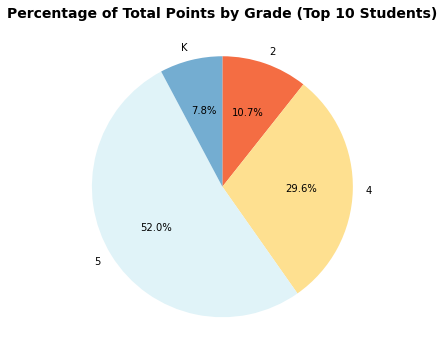

In [164]:
# Sum TotalPoints per grade among top 10 students
total_points_by_grade = top_10_students.groupby('Grade')['TotalPoints'].sum().sort_index()

# Pie chart
plt.figure(figsize=(6,6))
total_points_by_grade.plot.pie(
    autopct='%1.1f%%',                # show percentage
    colors=sns.color_palette('RdYlBu', len(total_points_by_grade)),  # nice colors
    startangle=90,
    counterclock=False
)
plt.ylabel('')  # remove default y-label
plt.title("Percentage of Total Points by Grade (Top 10 Students)", fontsize=14, fontweight='bold')
plt.show()

<div class="alert alert-block alert-info">
This bar chart shows the number of top 10 students from each grade, providing a clear view of grade-level representation in the highest-performing group.
</div>

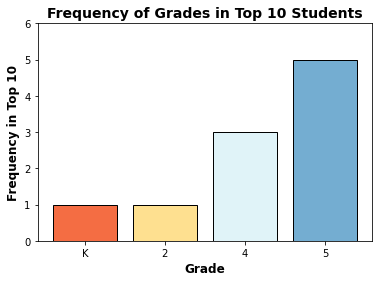

In [165]:
# Desired grade order
grade_order = ['K', '2', '4', '5']  

# Reindex counts to match order
grade_counts = top_10_students['Grade'].value_counts().reindex(grade_order).fillna(0)

# Get colors from Seaborn RdYlBu palette (as many as grades)
colors = sns.color_palette("RdYlBu", n_colors=len(grade_order))

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(grade_counts.index, grade_counts.values, color=colors, edgecolor='black')
plt.title("Frequency of Grades in Top 10 Students", fontsize=14, fontweight='bold')
plt.xlabel("Grade", fontsize=12, fontweight='bold')
plt.ylabel("Frequency in Top 10", fontsize=12, fontweight='bold')
plt.ylim(0, max(grade_counts.values)+1)
plt.show()

### Top Student Per Class

The top student in each class is highlighted here to recognize individual excellence and provide benchmarks for comparison within each grade.

**Insights:**  
- Highlights individual excellence within each classroom.  
- Provides teachers with a clear view of their top-performing student.  
- Supports recognition and encourages continued engagement in reading.

In [166]:
top_students_per_class = (
    MMRC_df.sort_values(['Grade','Teacher','TotalPoints'], ascending=[True,True,False])
    .groupby(['Grade','Teacher']).first().reset_index()
)
top_students_per_class = set_grade_order(top_students_per_class)
display(top_students_per_class[['Grade','Teacher','Student','TotalPoints']].style.hide(axis='index'))

Grade,Teacher,Student,TotalPoints
K,Waldems,Aadhiran,1185
K,Hilborrow,Eliza,785
K,Boulker,Andrew,2810
K,Patterson,Kaleb,941
1,Booth,Aarunya,1065
1,Brooks,Nathan,1007
1,Leigh,Virat,735
1,Miller,Austin J,1040
2,McMahon,Lincoln,540
2,Palache,Monya,3850


<div class="alert alert-block alert-info">
The horizontal bar chart shows each top student's total reading minutes, with bars grouped by teacher and colored by grade. This visualization allows for quick comparison of top performers across classes and grades.
</div>

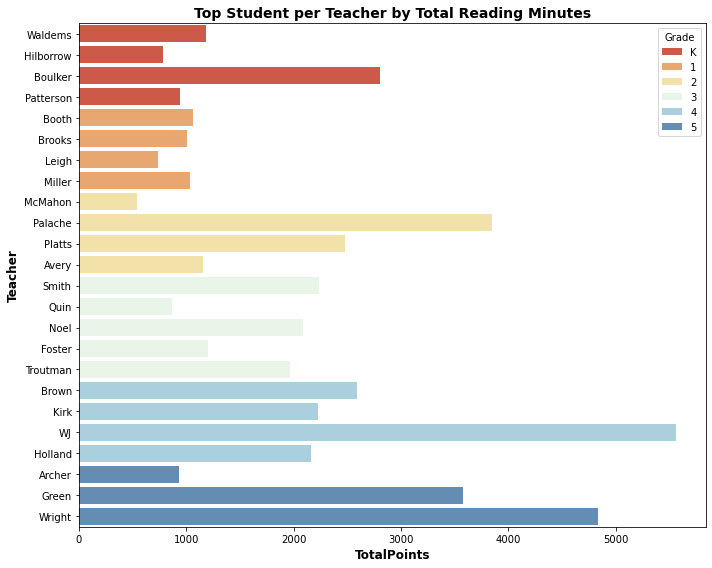

In [167]:
plt.figure(figsize=(10,8))
sns.barplot(
    data=top_students_per_class,
    palette='RdYlBu',
    y='Teacher', 
    x='TotalPoints', 
    hue='Grade', 
    dodge=False
)
plt.title("Top Student per Teacher by Total Reading Minutes", fontsize=14, fontweight='bold')
plt.xlabel("TotalPoints", fontsize=12, fontweight='bold')
plt.ylabel("Teacher", fontsize=12, fontweight='bold')
plt.legend(title='Grade')
plt.tight_layout()
plt.show()

### Top Class Per Grade

The class with the highest total reading points in each grade is highlighted here to showcase collective achievement and encourage best practices across classrooms.

**Insights:**  
- Recognizes high-performing classes and encourages sharing of successful strategies.  
- Supports administrative decisions to replicate best practices across grades. 
- Provides a clear view of which classrooms are achieving the highest cumulative reading minutes.

In [168]:
total_points_per_class = MMRC_df.groupby(['Grade','Teacher'])['TotalPoints'].sum().reset_index()
top_class_per_grade = total_points_per_class.loc[total_points_per_class.groupby('Grade')['TotalPoints'].idxmax()]
top_class_per_grade = top_class_per_grade.sort_values(by='TotalPoints', ascending=False)
display(top_class_per_grade.style.hide(axis='index'))

Grade,Teacher,TotalPoints
4,WJ,19114
5,Wright,18244
3,Smith,11621
2,Palache,10864
K,Boulker,10545
1,Miller,3918


<div class="alert alert-block alert-info">
The bar chart shows total reading minutes of the top class per grade, with each bar labeled by the class teacher. This visualization allows for quick comparison of top-performing classes across grades.
</div>

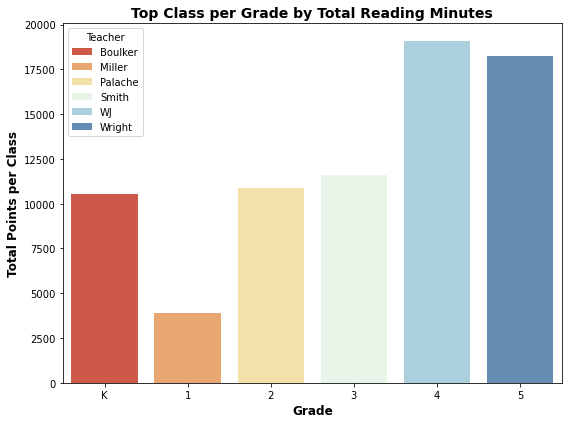

In [169]:
# Ensure grades are ordered correctly
top_class_per_grade = set_grade_order(top_class_per_grade)

plt.figure(figsize=(8,6))
sns.barplot(
    data=top_class_per_grade,
    x='Grade',
    y='TotalPoints',
    hue='Teacher',       # shows which class is top in that grade
    dodge=False,         # one bar per grade
    palette=sns.color_palette('RdYlBu', len(top_class_per_grade))
)
plt.title("Top Class per Grade by Total Reading Minutes", fontsize=14, fontweight='bold')
plt.xlabel("Grade", fontsize=12, fontweight='bold')
plt.ylabel("Total Points per Class", fontsize=12, fontweight='bold')
plt.legend(title="Teacher")
plt.tight_layout()
plt.show()

[Back to top](#Top)
<a class="anchor" id="sec_3"></a>
***
## **<font color='#f46d43'>Identifying Students for Targeted Support</font>**

**Objective:** Highlight students who may need additional support by focusing on those with zero total reading points, enabling targeted, data-driven interventions.

1. **Student Participation**  
   - Shows which students actively contributed reading points.  
   - Helps administrators and teachers see which classes have higher engagement.
<br><br>
2. **Zero-Point Students Per Grade**  
   - Aggregates students with 0 total points per grade.  
   - Highlights grades with the largest proportion of at-risk students.
<br><br>
3. **Teachers With Most Zero-Point Students**  
   - Counts zero-point students per teacher/class.  
   - Identifies classes requiring targeted interventions and additional support.

After this analysis, administrators and teachers can prioritize interventions, monitor engagement, and implement targeted strategies to support at-risk students.

### Student Participation

Students who actively contributed reading points are highlighted here to show engagement levels across grades and classes.

**Insights:**  
- Shows which students are participating in the reading challenge.  
- Allows administrators and teachers to see which classes are fully engaged.  
- Provides a basis for recognizing active students and encouraging further participation.

In [170]:
# Filter out students with 0 points
participating_students = MMRC_df[MMRC_df['TotalPoints'] > 0]

# Count number of participating students per Grade and Teacher
participation_counts = participating_students.groupby(['Grade','Teacher']).size().reset_index(name='NumParticipants')

# Display the table
participation_counts = set_grade_order(participation_counts)
display(participation_counts.style.hide(axis='index'))

Grade,Teacher,NumParticipants
K,Waldems,13
K,Hilborrow,12
K,Boulker,12
K,Patterson,10
1,Booth,11
1,Brooks,11
1,Leigh,10
1,Miller,11
2,McMahon,13
2,Palache,16


<div class="alert alert-block alert-info">
The bar chart shows the number of students participating per grade and class, providing a clear view of engagement across the school.
</div>

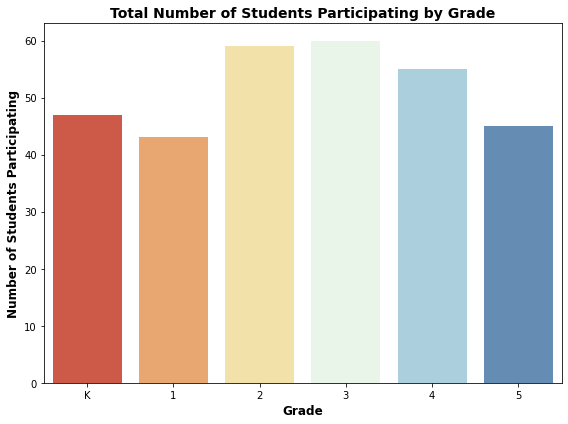

In [171]:
# Filter out students with 0 points
participating_students = MMRC_df[MMRC_df['TotalPoints'] > 0]

# Count total participants per grade
participants_per_grade = participating_students.groupby('Grade').size().reset_index(name='NumParticipants')

participants_per_grade = set_grade_order(participants_per_grade)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=participants_per_grade,
    x='Grade',
    y='NumParticipants',
    palette=sns.color_palette("RdYlBu")
)
plt.title("Total Number of Students Participating by Grade", fontsize=14, fontweight='bold')
plt.xlabel("Grade", fontsize=12, fontweight='bold')
plt.ylabel("Number of Students Participating", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Count of Zero-Point Students Per Grade

Students with zero total reading points are highlighted here to identify grades with the largest proportion of at-risk students.

**Insights:**  
- Reveals grades where engagement is lowest.  
- Helps prioritize where additional support or encouragement may be needed.  
- Provides a high-level view of potential risk areas for reading participation.

#### Count of non-participants by grade

In [172]:
zero_points_per_grade = MMRC_df[MMRC_df['TotalPoints'] == 0]\
                        .groupby('Grade').size().reset_index(name='Students with 0 Points')
zero_points_per_grade = set_grade_order(zero_points_per_grade)
display(zero_points_per_grade.style.hide(axis='index'))

Grade,Students with 0 Points
K,4
1,10
2,6
3,12
4,21
5,23


#### Count of non-participants by teacher

In [173]:
zero_points_per_teacher = MMRC_df[MMRC_df['TotalPoints'] == 0]\
                          .groupby(['Grade','Teacher']).size().reset_index(name='ZeroPointCount')\
                          .sort_values(by='ZeroPointCount', ascending=False)
display(zero_points_per_teacher.head(10).style.hide(axis='index'))

Grade,Teacher,ZeroPointCount
5,Green,12
4,Holland,7
5,Archer,6
4,Brown,6
4,Kirk,5
5,Wright,5
3,Noel,4
3,Quin,4
2,McMahon,4
1,Leigh,4


[Back to top](#Top)
<a class="anchor" id="sec_4"></a>
***
## **<font color='#f46d43'>Reading Log Progression Trends (Weeks 1 → 4)</font>**

**Objective:** Track student and class performance across the four reading logs to identify growth patterns and areas needing attention.

1. **Class Reading Log Trends**  
   - Aggregates total reading points for each class across Reading Log Weeks 1 through 4.  
   - Visualizes class-level performance over time to identify improvement, stagnation, or decline.

After this analysis, administrators and teachers can monitor reading growth patterns, identify classes needing targeted support, and replicate strategies from high-performing classes.

### Generating & Plotting Per-Grade Trends

This subsection aggregates total reading points for each reading log (RL1–RL4) per class within each grade and visualizes performance over time. The data is reshaped to a long format to facilitate comparison across classes.

**Insights:**  
- Shows week-to-week reading progress for each class.  
- Identifies trends of improvement, stagnation, or decline.  
- Allows administrators and teachers to benchmark classes and share effective strategies.

In [17]:
grade_order = ['K','1','2','3','4','5']
MMRC_df['Grade'] = pd.Categorical(MMRC_df['Grade'], categories=grade_order, ordered=True)

# Define grade names for plot titles
grade_names = {'K':'K','1':'1st','2':'2nd','3':'3rd','4':'4th','5':'5th'}

<div class="alert alert-block alert-info">
The line charts display class-level progression for each grade, providing a clear view of reading performance trends over the four weeks.
</div>

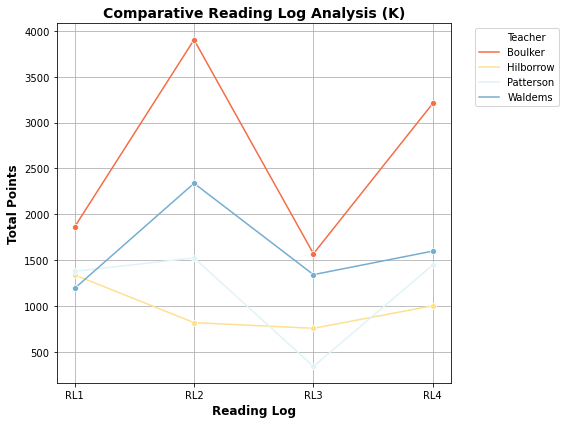

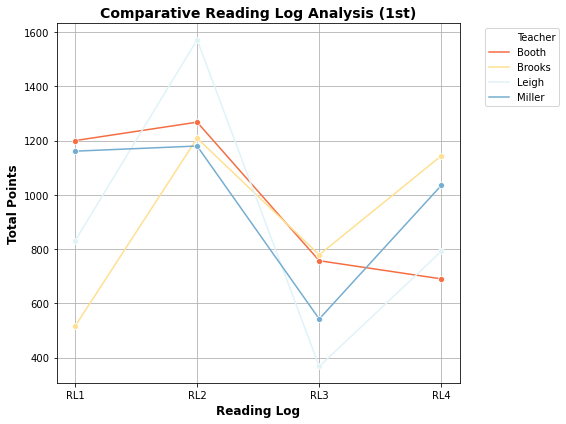

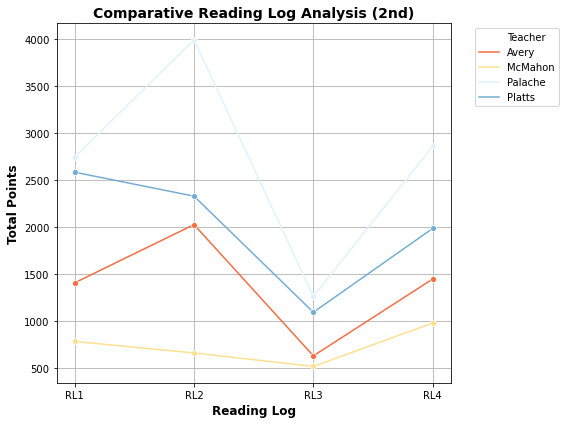

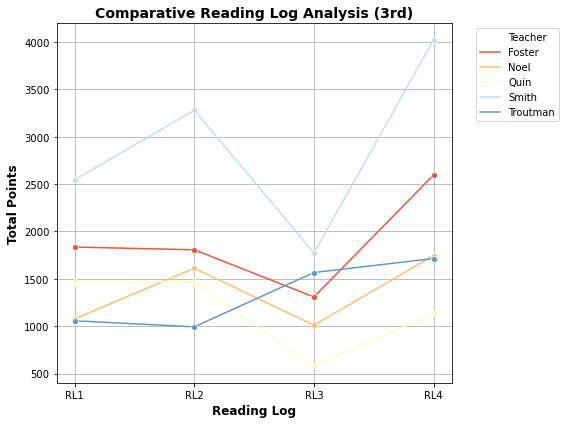

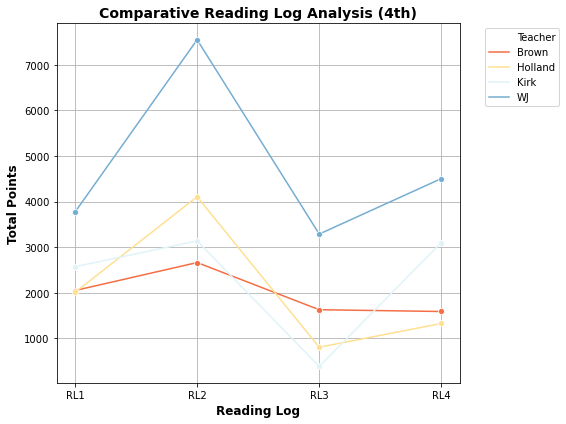

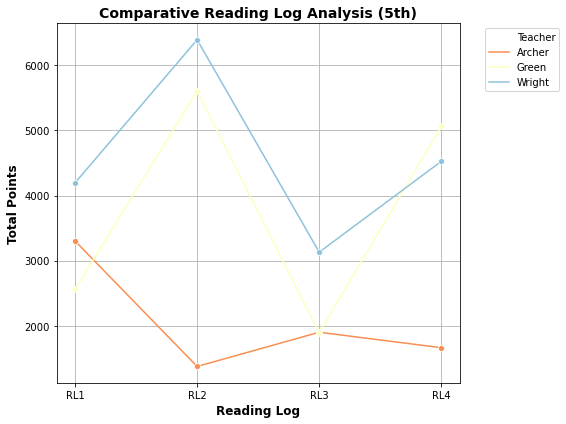

In [18]:
# Loop through grades
for g in MMRC_df['Grade'].cat.categories:
    df_grade = MMRC_df[MMRC_df['Grade'] == g]
    
    # Aggregate total points per class for each reading log
    df_trends = df_grade.groupby('Teacher')[['RL1','RL2','RL3','RL4']].sum().reset_index()
    
    # Reshape from wide to long for plotting
    df_long = df_trends.melt(
        id_vars='Teacher',
        value_vars=['RL1','RL2','RL3','RL4'],
        var_name='RL',
        value_name='TotalPoints'
    )
    
    plt.figure(figsize=(8,6))
    
    # Dynamically generate color palette
    n_classes = df_long['Teacher'].nunique()
    colors = sns.color_palette("RdYlBu", n_classes)
    
    sns.lineplot(
        data=df_long,
        x='RL',
        y='TotalPoints',
        hue='Teacher',
        marker='o',
        palette=colors
    )
    
    plt.title(f"Comparative Reading Log Analysis ({grade_names[g]})", fontsize=14, fontweight='bold')
    plt.xlabel("Reading Log", fontsize=12, fontweight='bold')
    plt.ylabel("Total Points", fontsize=12, fontweight='bold')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

[Back to top](#Top)
<a class="anchor" id="sec_5"></a>
***
## **<font color='#f46d43'>Class Performance Distribution & Outliers</font>**

**Objective:** Examine how student performance varies within and across classes and identify outliers to highlight exceptional or struggling students.

1. **Average Points Per Student Per Class**  
   - Computes the mean total points per student for each class.  
   - Provides an overview of typical student performance and allows comparison across classes.
<br><br>
2. **Identify Outliers Using IQR**  
   - Detects extremely high or low total points using the Interquartile Range (IQR) method.  
   - Helps administrators and teachers identify students who may need additional support or enrichment.
<br><br>
3. **Total Points Distribution & Outliers By Teacher**  
   - Visualizes student performance distribution per teacher/class in boxplots, with outliers highlighted.  
   - Highlights classes with multiple low-performing or high-performing students and supports data-driven instructional decisions.

After this analysis, administrators and teachers can understand performance variability, recognize top performers, and implement targeted support for students at risk.

### Average Points Per Student Per Class

This subsection computes the mean total reading points per student for each class, providing a clear view of typical performance within each classroom.

**Insights:**  
- Shows the average engagement level of students in each class.  
- Allows comparison across classes to identify strong and weaker-performing classrooms.  
- Helps teachers understand overall class performance and set appropriate reading goals.

In [15]:
df_avg = MMRC_df.groupby(['Grade','Teacher','Student'])['TotalPoints'].mean().reset_index()
df_avg = set_grade_order(df_avg)

<div class="alert alert-block alert-info">
The boxplots visualize the distribution of total points per student for each teacher/class, highlighting differences in performance between classrooms.
</div>

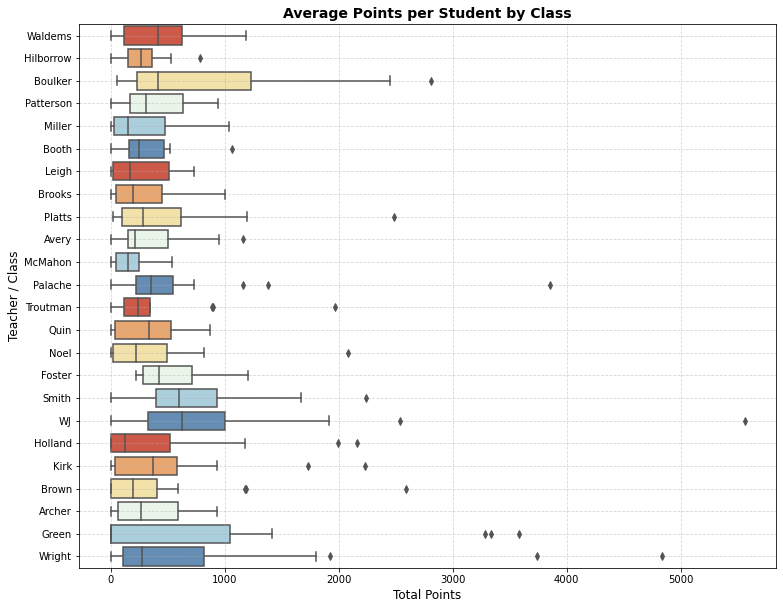

In [16]:
plt.figure(figsize=(12.5,10))
sns.boxplot(data=df_avg, y='Teacher', x='TotalPoints', palette=sns.color_palette("RdYlBu"))
plt.title("Average Points per Student by Class", fontsize=14, fontweight='bold')
plt.xlabel("Total Points", fontsize=12)
plt.ylabel("Teacher / Class", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### **Identify Outliers Using IQR**

This subsection detects students with extremely high or low total reading points using the Interquartile Range (IQR) method. Outliers are highlighted to identify students who may need additional support or enrichment.

**Insights:**  
- Identifies students performing significantly below or above their peers.  
- Helps teachers target interventions for struggling students.  
- Recognizes high-performing students who may benefit from enrichment opportunities.

The method flags low and high outliers, providing a clear visual representation of extreme values in student reading performance.

In [178]:
Q1 = MMRC_df['TotalPoints'].quantile(0.25)
Q3 = MMRC_df['TotalPoints'].quantile(0.75)
IQR = Q3 - Q1
outliers = MMRC_df[(MMRC_df['TotalPoints'] < Q1 - 1.5*IQR) | (MMRC_df['TotalPoints'] > Q3 + 1.5*IQR)]

### Total Points Distribution & Outliers By Teacher

This subsection visualizes the distribution of total reading points for each teacher/class using boxplots, with outliers highlighted. It provides a clear view of student performance variability across classrooms.

**Insights:**  
- Highlights classes with multiple low-performing or high-performing students. 
- Helps administrators and teachers identify trends in performance across teachers.  
- Supports data-driven instructional decisions by showing where targeted support or enrichment is needed.

<div class="alert alert-block alert-info">
The Boxplot displays the spread of total points per student for each teacher/class, with extreme values marked to emphasize outliers.
</div>

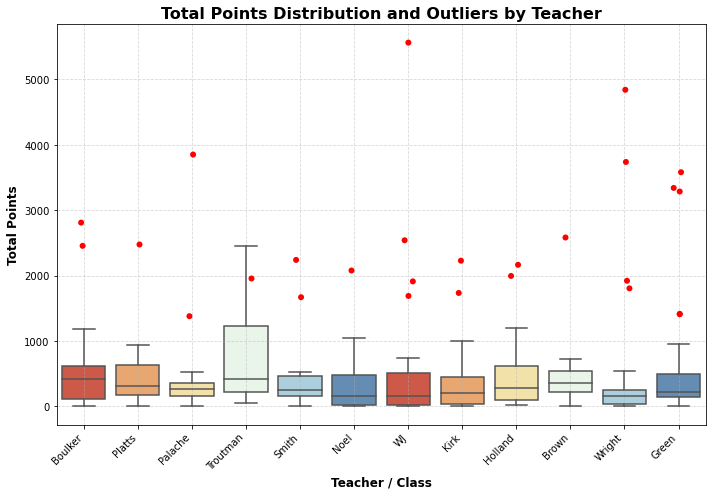

In [179]:
# Boxplot per teacher with outliers
plt.figure(figsize=(10,7))
sns.boxplot(data=MMRC_df, x='Teacher', y='TotalPoints', palette=sns.color_palette("RdYlBu"), showfliers=False)
sns.stripplot(data=outliers, x='Teacher', y='TotalPoints', color='red', size=6, jitter=True)
plt.title('Total Points Distribution and Outliers by Teacher', fontsize=16, fontweight='bold')
plt.xlabel('Teacher / Class', fontsize=12, fontweight='bold')
plt.ylabel('Total Points', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

[Back to top](#Top)
***

## **<font color='#f46d43'>Conclusion</font>**

The March Madness Reading Challenge analysis provides a comprehensive view of student reading engagement across grades, classes, and teachers. By examining overall performance, top achievers, students needing support, reading progression trends, and class-level distributions, this report delivers actionable insights for administrators and educators.

**Key Takeaways:**  
- Recognizing top performers allows for celebration of success and sets benchmarks for other students.  
- Tracking students with zero or low reading points helps identify those who may benefit from targeted interventions.  
- Analyzing week-to-week reading trends highlights growth patterns and areas requiring additional support.  
- Class-level performance distributions and outlier detection inform instructional strategies and resource allocation.  

Overall, this analysis equips administrators and teachers with the data needed to monitor engagement, support at-risk students, and replicate effective strategies across classrooms, ensuring that the March Madness Reading Challenge maximizes reading growth for all students.

[Back to top](#Top)
***